In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import skew, kurtosis

import os
import zipfile
import shutil

In [1]:
# set up everything to download data from Kaggle
!pip install kaggle

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True) # create the .kaggle directory if it doesn't exist
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json')) # move kaggle.json to the .kaggle directory
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600) # set correct permissions for the file

  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105839 sha256=753b82cf107f88ca70ab83e46ab8a21ba66170c4202dab94f34781860f183b1f
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle


In [7]:
# Download the Movies Dataset
!kaggle datasets download -d bharatnatrayn/movies-dataset-for-feature-extracion-prediction

# Unzip the dataset
with zipfile.ZipFile('movies-dataset-for-feature-extracion-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('movies_dataset')

# Check the extracted files
os.listdir('movies_dataset')

Dataset URL: https://www.kaggle.com/datasets/bharatnatrayn/movies-dataset-for-feature-extracion-prediction
License(s): CC0-1.0
 95%|████████████████████████████████████▏ | 1.00M/1.05M [00:00<00:00, 2.02MB/s]
100%|██████████████████████████████████████| 1.05M/1.05M [00:00<00:00, 2.10MB/s]


['movies.csv']

In [52]:
df = pd.read_csv('movies_dataset/movies.csv')
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


# Data Cleaning
## Handling missing data

Identify Missing Data:
- Use .isnull() or .isna() (in Python pandas) to check for missing values.
- Metric: Percentage of missing values.

In [53]:
print('Size of the dataset:', df.shape)

missing_percentages = (df.isnull().sum() / len(df)) * 100
missing_data = pd.DataFrame({
        'Column': missing_percentages.index,
        'Missing_Percentage': missing_percentages.values
    })
missing_data = missing_data.sort_values(by='Missing_Percentage', ascending=False).reset_index(drop=True)
print(missing_data)   

Size of the dataset: (9999, 9)
     Column  Missing_Percentage
0     Gross           95.399540
1   RunTime           29.582958
2    RATING           18.201820
3     VOTES           18.201820
4      YEAR            6.440644
5     GENRE            0.800080
6    MOVIES            0.000000
7  ONE-LINE            0.000000
8     STARS            0.000000


Options to Handle Missing Data:
- Remove rows/columns with too many missing values.
- Impute missing values:
    - Mean/Median (for numerical data).
    - Mode (for categorical data).
    - Interpolation or advanced techniques (e.g., KNN imputation).

In [54]:
# Option 1: Drop columns with more than 20% missing values
threshold = 20 
columns_to_drop = missing_data[missing_data['Missing_Percentage'] > threshold]['Column']
movies_df_cleaned = movies_df.drop(columns=columns_to_drop)
print(f"\nDropped columns with >{threshold}% missing values: {columns_to_drop.tolist()}")

# Option 2: Impute missing values

# For NUMERICAL columns, fill missing values with the column mean
numerical_columns = movies_df_cleaned.select_dtypes(include=['float64', 'int64']).columns
#print('Numerical columns: ', numerical_columns)

for col in numerical_columns:
    if movies_df_cleaned[col].isnull().sum() > 0:
        movies_df_cleaned[col] = movies_df_cleaned[col].fillna(movies_df_cleaned[col].mean())
        print(f"Filled missing values in numerical column '{col}' with mean.")

# For CATEGORICAL columns, fill missing values with the column MODE
categorical_columns = movies_df_cleaned.select_dtypes(include=['object']).columns
#print('Categorical columns: ', categorical_columns)

for col in categorical_columns:
    if movies_df_cleaned[col].isnull().sum() > 0:
        movies_df_cleaned[col] = movies_df_cleaned[col].fillna(movies_df_cleaned[col].mode()[0])
        print(f"Filled missing values in categorical column '{col}' with mode.")


Dropped columns with >20% missing values: ['Gross', 'RunTime']
Filled missing values in numerical column 'RATING' with mean.
Filled missing values in categorical column 'YEAR' with mode.
Filled missing values in categorical column 'GENRE' with mode.
Filled missing values in categorical column 'VOTES' with mode.


In [55]:
# movies_df_cleaned.to_csv('cleaned_movies.csv', index=False) # save the cleaned DataFrame (optional)

print("\nCleaned DataFrame:")
print(movies_df_cleaned.info())


Cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9999 non-null   object 
 2   GENRE     9999 non-null   object 
 3   RATING    9999 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     9999 non-null   object 
dtypes: float64(1), object(6)
memory usage: 546.9+ KB
None


##  Identify and handle outliers 
(using Interquartile Range (IQR) and Z-Score methods)

Identify Outliers using IQR and Z-Score:
- Use IQR method to identify data points outside Q1 - 1.5 * IQR and Q3 + 1.5 * IQR.
- Use Z-Score method to identify data points with a Z-score greater than 3 or less than -3.

In [56]:
# calculate IQR and identify outliers

def identify_outliers_iqr(df, numerical_columns):
    outliers = {}
    for col in numerical_columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # identify outliers
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        #print(f"Outliers in {col} using IQR method:")
        #print(outliers[col])
        
    return outliers

numerical_columns = movies_df_cleaned.select_dtypes(include=['float64', 'int64']).columns
outliers_iqr = identify_outliers_iqr(movies_df_cleaned, numerical_columns)

In [57]:
# calculate Z-Score and identify outliers
def identify_outliers_zscore(df, numerical_columns):
    outliers_zscore = {}
    for col in numerical_columns:
        # Calculate Z-scores
        z_scores = zscore(df[col].dropna())  # Remove NaN for Z-score calculation
        abs_z_scores = np.abs(z_scores)
        
        # Identify outliers where Z-score > 3 or < -3
        outliers_zscore[col] = df[abs_z_scores > 3]
        
        #print(f"Outliers in {col} using Z-Score method:")
        #print(outliers_zscore[col])
    
    return outliers_zscore

outliers_zscore = identify_outliers_zscore(movies_df_cleaned, numerical_columns)

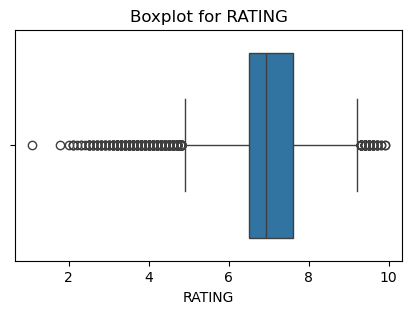

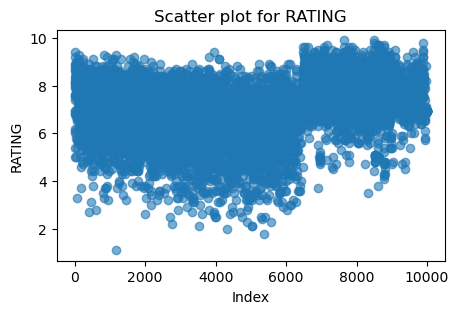

In [58]:
# visualize outliers using boxplot and scatterplot
def visualize_outliers(df, numerical_columns):
    for col in numerical_columns:
        plt.figure(figsize=(5, 3))
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot for {col}')
        plt.show()

def scatterplot_outliers(df, numerical_columns):
    for col in numerical_columns:
        plt.figure(figsize=(5, 3))
        plt.scatter(df.index, df[col], alpha=0.6, label=col)
        plt.title(f'Scatter plot for {col}')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.show()

visualize_outliers(movies_df_cleaned, numerical_columns)
scatterplot_outliers(movies_df_cleaned, numerical_columns)

Then we have to handle all of the outliers with the 'remove' or 'transform' methods. This choise depends on our business logic. 

We take the logarithm of each value in a dataset, often to make the data distribution more normal (i.e., symmetric). 

This transformation is especially useful for data that is skewed or has outliers.

In [59]:
def handle_outliers(df, numerical_columns, outliers_iqr, outliers_zscore, method='remove'):
    if method == 'remove':
        # Remove rows that are outliers based on IQR or Z-Score
        indices_to_remove = set()
        for col in numerical_columns:
            indices_to_remove.update(outliers_iqr[col].index)
            indices_to_remove.update(outliers_zscore[col].index)
        df_cleaned = df.drop(indices_to_remove)
        print(f"Rows removed due to outliers: {len(indices_to_remove)}")      
    
    elif method == 'transform': 
        # Apply log transformation to handle outliers (if data is positively skewed)
        df_cleaned = df.copy()
        for col in numerical_columns:
            if df[col].min() > 0:  # Apply log only if data is positive
                df_cleaned[col] = np.log(df[col])
                print(f"Log-transformed column: {col}")
    else:
        # Just return the original dataframe if no handling method is chosen
        df_cleaned = df
        print("No handling method selected. Returning the original dataframe.")
    
    return df_cleaned

movies_df_cleaned = handle_outliers(movies_df_cleaned, numerical_columns, outliers_iqr, outliers_zscore, method='remove')
print("\nCleaned DataFrame:")
print(movies_df_cleaned.info())

Rows removed due to outliers: 607

Cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 9392 entries, 0 to 9998
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9392 non-null   object 
 1   YEAR      9392 non-null   object 
 2   GENRE     9392 non-null   object 
 3   RATING    9392 non-null   float64
 4   ONE-LINE  9392 non-null   object 
 5   STARS     9392 non-null   object 
 6   VOTES     9392 non-null   object 
dtypes: float64(1), object(6)
memory usage: 587.0+ KB
None


## Additional steps

1. Standardizing Data => scale numerical data
- When variables have different units (e.g., height in cm vs. weight in kg), standardize using z-scores or min-max scaling.

2. Encoding Categorical Data => convert categorical data into numerical form
- One-hot encoding for nominal data (e.g., gender: male/female → `[1, 0]` or `[0, 1]`).
- Label encoding for ordinal data (e.g., low/medium/high → 0, 1, 2).

3. Removing Duplicates
- Check for duplicate rows using `.duplicated()` and remove them to avoid bias.

# Metrics to understand your data

## Descriptive Statistics
Use these to summarize and describe the key features of your dataset.

- Mean, Median, Mode: Central tendency.
- Variance, Standard Deviation: Spread of the data.
- Range: Minimum to maximum.
- IQR: Middle 50% range (less sensitive to outliers).

## Data Distribution

Check the shape of your data:
Visualize using histograms, box plots, or density plots.

Metric: Skewness and Kurtosis.
- Skewness:
    - 0: Symmetrical.
    - `>0`: Right-skewed.
    - <0: Left-skewed.
- Kurtosis:
    - 3: Normal distribution.
    - `>3`: Heavy tails (leptokurtic).
    - <3: Light tails (platykurtic).

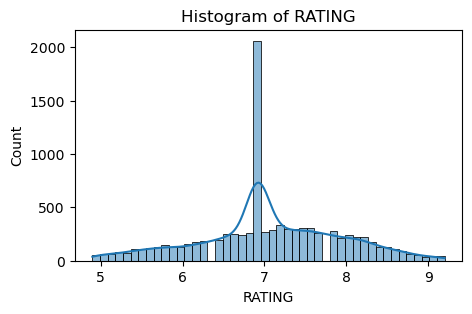

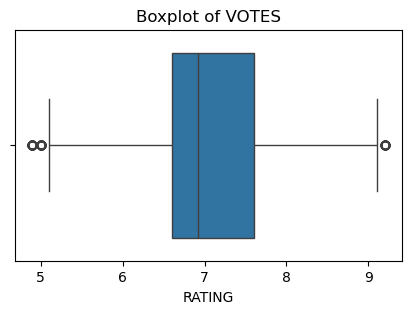


Skewness of RATING: -0.106228531985501
Kurtosis of RATING: -0.07460322864621105


In [68]:
# Visualizations: Histogram, Boxplot, Density Plot
plt.figure(figsize=(5, 3))
sns.histplot(movies_df_cleaned['RATING'], kde=True)  # Example for 'RATING' column
plt.title('Histogram of RATING')
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(x=movies_df_cleaned['RATING'])
plt.title('Boxplot of VOTES')
plt.show()

# Skewness and Kurtosis
skewness = skew(movies_df_cleaned['RATING'])
kurt = kurtosis(movies_df_cleaned['RATING'])

print("\nSkewness of RATING:", skewness)
print("Kurtosis of RATING:", kurt)

## Correlation

Pairwise Correlation (for continuous variables):
- Metric: Pearson’s (r), Spearman’s (ρ), or Kendall’s (τ).

Use `.corr()` in pandas for a correlation matrix.

Correlation helps identify multicollinearity (highly correlated independent variables).

## Categorical Data Analysis

Count unique categories with `.value_counts()`.

Visualize distributions using bar plots or pie charts.


Pearson's Correlation Matrix:
        RATING
RATING     1.0

Spearman's Correlation Matrix:
        RATING
RATING     1.0

Kendall's Correlation Matrix:
        RATING
RATING     1.0


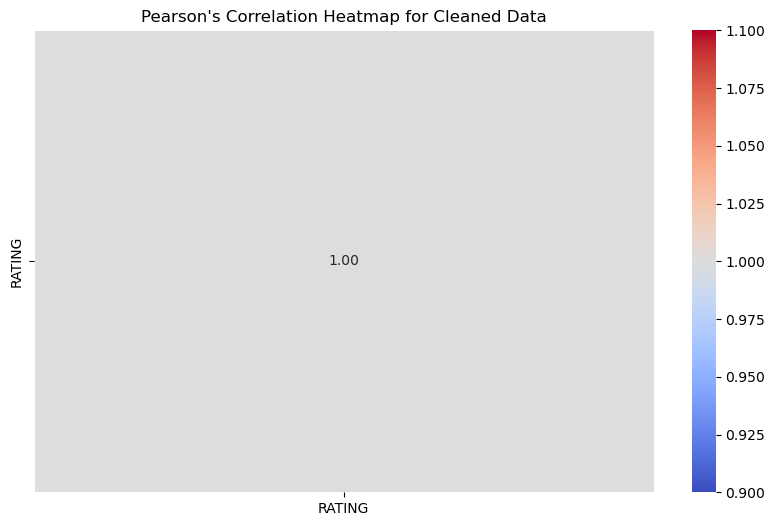

In [73]:
# Select only numeric columns for correlation
numeric_columns = movies_df_cleaned.select_dtypes(include=[np.number]).columns

# Pearson's correlation matrix (for continuous numerical columns)
correlation_pearson = movies_df_cleaned[numeric_columns].corr(method='pearson')
print("\nPearson's Correlation Matrix:")
print(correlation_pearson)

# Spearman's correlation matrix (for non-parametric or ordinal data)
correlation_spearman = movies_df_cleaned[numeric_columns].corr(method='spearman')
print("\nSpearman's Correlation Matrix:")
print(correlation_spearman)

# Kendall's correlation matrix (another non-parametric correlation method)
correlation_kendall = movies_df_cleaned[numeric_columns].corr(method='kendall')
print("\nKendall's Correlation Matrix:")
print(correlation_kendall)

# Visualizing the Pearson's Correlation Heatmap for the cleaned dataset
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_pearson, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Pearson's Correlation Heatmap for Cleaned Data")
plt.show() # => looks stupid, because we have only one numeric column

## Chosing the right statistical test

**Which type of data do we have?**

a) Numerical Data:
- Continuous: e.g., height, weight.
- Discrete: e.g., number of children.

b) Categorical Data:
- Nominal: No order (e.g., colors, gender).
- Ordinal: Has order (e.g., low, medium, high).



**What is the distribution of our data?**

a) Check if data follows a normal distribution.
- Shapiro-Wilk Test.
- Kolmogorov-Smirnov Test.
- Visualization: Histogram, Q-Q Plot.

If data is not normal => Use non-parametric tests (e.g., Mann-Whitney U, Kruskal-Wallis).

b) Check if variances across groups are equal.
- Levene’s Test.

If variances are not equal => Use Welch’s t-Test or non-parametric tests.



**How many groups do we have?**

1) Two Groups
- Parametric => t-Test (independent or paired).
- Non-Parametric => Mann-Whitney U Test/Wilcoxon Signed-Rank Test

2) Three or More Groups:
- Parametric => ANOVA (One-Way or Two-Way).
- Non-Parametric => Kruskal-Wallis Test.

3) Relationships Between Variables:
- Continuous => Correlation (Pearson, Spearman)/Linear Regression.
- Categorical => Chi-Square Test/Logistic Regression.


**PS: If the P-value is < than 0.05, we would REJECT the null hypothesis!!!**